In [ ]:
#| echo: false

# This cell will not be rendered but is to hide warnings and limit the rows shown

import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger('statsforecast').setLevel(logging.ERROR)

import pandas as pd
pd.set_option('display.max_rows', 6)

# Simple Exponential Smoothing Model

> Step-by-step guide on using the `SimpleExponentialSmoothing Model` with `Statsforecast`.

During this walkthrough, we will become familiar with the main `StatsForecast` class and some relevant methods such as `StatsForecast.plot`, `StatsForecast.forecast` and `StatsForecast.cross_validation` in other.

The text in this article is largely taken from:
1. [Changquan Huang • Alla Petukhina. Springer series (2022). Applied Time Series Analysis and Forecasting with Python.](https://link.springer.com/book/10.1007/978-3-031-13584-2) 
2. Ivan Svetunkov. [Forecasting and Analytics with the Augmented Dynamic Adaptive Model (ADAM)](https://openforecast.org/adam/)
3. [James D. Hamilton. Time Series Analysis Princeton University Press, Princeton, New Jersey, 1st Edition, 1994.](https://press.princeton.edu/books/hardcover/9780691042893/time-series-analysis)
4. [Rob J. Hyndman and George Athanasopoulos (2018). “Forecasting Principles and Practice (3rd ed)”](https://otexts.com/fpp3/tscv.html).

## Table of Contents

* [Introduction](#introduction)
* [Simple Exponential Smoothing](#model)
* [Loading libraries and data](#loading)
* [Explore data with the plot method](#plotting)
* [Split the data into training and testing](#splitting)
* [Implementation of SimpleExponentialSmoothing with StatsForecast](#implementation)
* [Cross-validation](#cross_validate)
* [Model evaluation](#evaluate)
* [References](#references)

## Introduction <a class="anchor" id="introduction"></a>

Exponential smoothing was proposed in the late 1950s (Brown, 1959; Holt, 1957; Winters, 1960), and has motivated some of the most successful forecasting methods. Forecasts produced using exponential smoothing methods are weighted averages of past observations, with the weights decaying exponentially as the observations get older. In other words, the more recent the observation the higher the associated weight. This framework generates reliable forecasts quickly and for a wide range of time series, which is a great advantage and of major importance to applications in industry.

The simple exponential smoothing model is a method used in time series analysis to predict future values based on historical observations. This model is based on the idea that future values of a time series will be influenced by past values, and that the influence of past values will decrease exponentially as you go back in time.

The simple exponential smoothing model uses a smoothing factor, which is a number between 0 and 1 that indicates the relative importance given to past observations in predicting future values. A value of 1 indicates that all past observations are given equal importance, while a value of 0 indicates that only the latest observation is considered.

The simple exponential smoothing model can be expressed mathematically as:

$$\hat{y}_{T+1|T} = \alpha y_T + \alpha(1-\alpha) y_{T-1} + \alpha(1-\alpha)^2 y_{T-2}+ \cdots,$$


where $y_T$ is the observed value in period $t$, $\hat{y}_{T+1|T}$ is the predicted value for the next period, y $(t-1)$ is the observed value in the previous period, and $\alpha$ is the smoothing factor.

The simple exponential smoothing model is a widely used forecasting model due to its simplicity and ease of use. However, it also has its limitations, as it cannot capture complex patterns in the data and is not suitable for time series with trends or seasonal patterns.

## Building of Simple exponential smoothing model <a class="anchor" id="model"></a>

The simplest of the exponentially smoothing methods is naturally called simple exponential smoothing (SES). This method is suitable for forecasting data with no clear trend or seasonal pattern.

Using the naïve method, all forecasts for the future are equal to the last observed value of the series,
$$\hat{y}_{T+h|T} = y_{T},$$

for $h=1,2,\dots$. Hence, the naïve method assumes that the most recent observation is the only important one, and all previous observations provide no information for the future. This can be thought of as a weighted average where all of the weight is given to the last observation.

Using the average method, all future forecasts are equal to a simple average of the observed data,
$$\hat{y}_{T+h|T} = \frac1T \sum_{t=1}^T y_t,$$

for $h=1,2,\dots$ Hence, the average method assumes that all observations are of equal importance, and gives them equal weights when generating forecasts.

We often want something between these two extremes. For example, it may be sensible to attach larger weights to more recent observations than to observations from the distant past. This is exactly the concept behind simple exponential smoothing. Forecasts are calculated using weighted averages, where the weights decrease exponentially as observations come from further in the past — the smallest weights are associated with the oldest observations:

\begin{equation}
  \hat{y}_{T+1|T} = \alpha y_T + \alpha(1-\alpha) y_{T-1} + \alpha(1-\alpha)^2 y_{T-2}+ \cdots,   \tag{1}
\end{equation}

where $0 \le \alpha \le 1$ is the smoothing parameter. The one-step-ahead forecast for time $T+1$ is a weighted average of all of the observations in the series $y_1,\dots,y_T$. The rate at which the weights decrease is controlled by the parameter $\alpha$.

For any $\alpha$ between 0 and 1, the weights attached to the observations decrease exponentially as we go back in time, hence the name “exponential smoothing”. If $\alpha$ is small (i.e., close to 0), more weight is given to observations from the more distant past. If $\alpha$ is large (i.e., close to 1), more weight is given to the more recent observations. For the extreme case where $\alpha=1$, $\hat{y}_{T+1|T}=y_T$ and the forecasts are equal to the naïve forecasts.

We present two equivalent forms of simple exponential smoothing, each of which leads to the forecast Equation (1).


### Weighted average form

The forecast at time $T+1$ is equal to a weighted average between the most recent observation $y_T$ and the previous forecast $\hat{y}_{T|T-1}$: 

$$\hat{y}_{T+1|T} = \alpha y_T + (1-\alpha) \hat{y}_{T|T-1},$$

where $0 \le \alpha \le 1$ is the smoothing parameter. Similarly, we can write the fitted values as
$$\hat{y}_{t+1|t} = \alpha y_t + (1-\alpha) \hat{y}_{t|t-1},$$

for $t=1,\dots,T$. (Recall that fitted values are simply one-step forecasts of the training data.)

The process has to start somewhere, so we let the first fitted value at time 1 be denoted by $\ell_{0}$ (which we will have to estimate). Then

\begin{align*}
  \hat{y}_{2|1} &= \alpha y_1 + (1-\alpha) \ell_0\\
  \hat{y}_{3|2} &= \alpha y_2 + (1-\alpha) \hat{y}_{2|1}\\
  \hat{y}_{4|3} &= \alpha y_3 + (1-\alpha) \hat{y}_{3|2}\\
  \vdots\\
  \hat{y}_{T|T-1} &= \alpha y_{T-1} + (1-\alpha) \hat{y}_{T-1|T-2}\\
  \hat{y}_{T+1|T} &= \alpha y_T + (1-\alpha) \hat{y}_{T|T-1}.
\end{align*}

Substituting each equation into the following equation, we obtain

\begin{align*}
  \hat{y}_{3|2}   & = \alpha y_2 + (1-\alpha) \left[\alpha y_1 + (1-\alpha) \ell_0\right]              \\
                 & = \alpha y_2 + \alpha(1-\alpha) y_1 + (1-\alpha)^2 \ell_0                          \\
  \hat{y}_{4|3}   & = \alpha y_3 + (1-\alpha) [\alpha y_2 + \alpha(1-\alpha) y_1 + (1-\alpha)^2 \ell_0]\\
                 & = \alpha y_3 + \alpha(1-\alpha) y_2 + \alpha(1-\alpha)^2 y_1 + (1-\alpha)^3 \ell_0 \\
                 & ~~\vdots                                                                           \\
  \hat{y}_{T+1|T} & =  \sum_{j=0}^{T-1} \alpha(1-\alpha)^j y_{T-j} + (1-\alpha)^T \ell_{0}.
\end{align*}

The last term becomes tiny for large $T$. So, the weighted average form leads to the same forecast Equation (1).

### Component form

An alternative representation is the component form. For simple exponential smoothing, the only component included is the level, $\ell_{t}$. Component form representations of exponential smoothing methods comprise a forecast equation and a smoothing equation for each of the components included in the method. The component form of simple exponential smoothing is given by:

\begin{align*}
  \text{Forecast equation}  && \hat{y}_{t+h|t} & = \ell_{t}\\
  \text{Smoothing equation} && \ell_{t}        & = \alpha y_{t} + (1 - \alpha)\ell_{t-1},
\end{align*}

where $\ell_{t}$ is the level (or the smoothed value) of the series at time $t$. Setting $h=1$ gives the fitted values, while setting $t=T$ gives the true forecasts beyond the training data.

The forecast equation shows that the forecast value at time $t+1$ is the estimated level at time $t$. The smoothing equation for the level (usually referred to as the level equation) gives the estimated level of the series at each period $t$.

If we replace $\ell_{t}$ with $\hat{y}_{t+1|t}$ and $\ell_{t-1}$ with $\hat{y}_{t|t-1}$ in the smoothing equation, we will recover the weighted average form of simple exponential smoothing.

The component form of simple exponential smoothing is not particularly useful on its own, but it will be the easiest form to use when we start adding other components.


### Flat forecasts

Simple exponential smoothing has a “flat” forecast function:

$$\hat{y}_{T+h|T} = \hat{y}_{T+1|T}=\ell_T, \qquad h=2,3,\dots.$$

That is, all forecasts take the same value, equal to the last level component. Remember that these forecasts will only be suitable if the time series has no trend or seasonal component.

## Loading libraries and data <a class="anchor" id="loading"></a>

:::{.callout-tip} 
Statsforecast will be needed. To install, see [instructions](../getting-started/0_Installation). 
:::

Next, we import plotting libraries and configure the plotting style.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.style.use('grayscale') # fivethirtyeight  grayscale  classic
plt.rcParams['lines.linewidth'] = 1.5
dark_style = {
    'figure.facecolor': '#008080',  # #212946
    'axes.facecolor': '#008080',
    'savefig.facecolor': '#008080',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': '#000000',  #2A3459
    'grid.linewidth': '1',
    'text.color': '0.9',
    'axes.labelcolor': '0.9',
    'xtick.color': '0.9',
    'ytick.color': '0.9',
    'font.size': 12 }
plt.rcParams.update(dark_style)


from pylab import rcParams
rcParams['figure.figsize'] = (18,7)

In [ ]:
import pandas as pd
df=pd.read_csv("https://raw.githubusercontent.com/Naren8520/Serie-de-tiempo-con-Machine-Learning/main/Data/ads.csv")
df.head()

,Time,Ads
0,2017-09-13T00:00:00,80115
1,2017-09-13T01:00:00,79885
2,2017-09-13T02:00:00,89325
3,2017-09-13T03:00:00,101930
4,2017-09-13T04:00:00,121630


The input to StatsForecast is always a data frame in long format with three columns: unique_id, ds and y:

* The `unique_id` (string, int or category) represents an identifier for the series.

* The `ds` (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp.

* The `y` (numeric) represents the measurement we wish to forecast.

In [ ]:
df["unique_id"]="1"
df.columns=["ds", "y", "unique_id"]
df

,ds,y,unique_id
0,2017-09-13T00:00:00,80115,1
1,2017-09-13T01:00:00,79885,1
2,2017-09-13T02:00:00,89325,1
...,...,...,...
213,2017-09-21T21:00:00,103080,1
214,2017-09-21T22:00:00,95155,1
215,2017-09-21T23:00:00,80285,1


In [ ]:
print(df.dtypes)

ds           object
y             int64
unique_id    object
dtype: object


In [ ]:
df["ds"] = pd.to_datetime(df["ds"])

## Explore Data with the plot method <a class="anchor" id="plotting"></a>

Plot some series using the plot method from the StatsForecast class. This method prints a random series from the dataset and is useful for basic EDA.

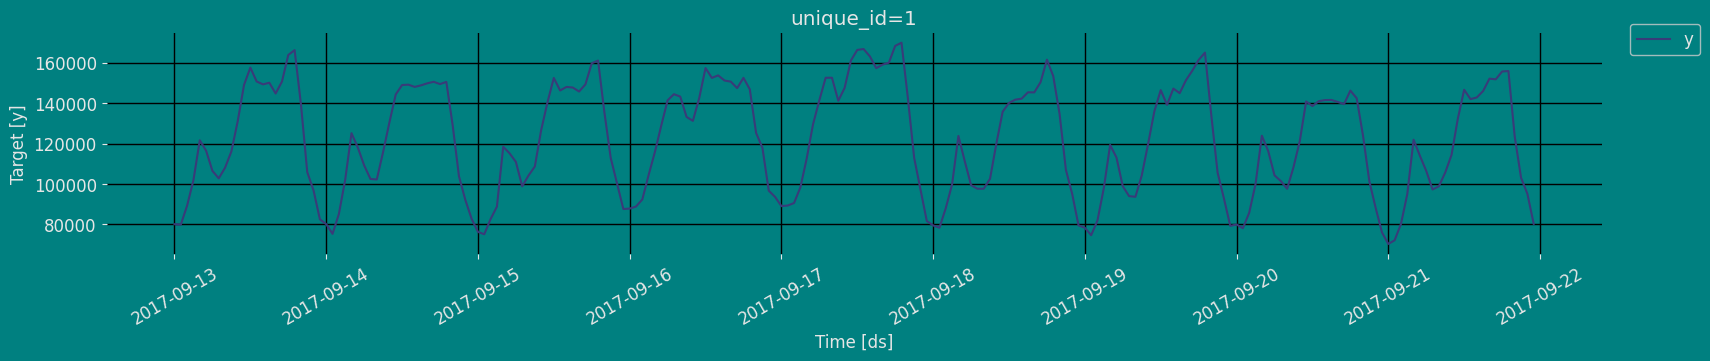

In [ ]:
from statsforecast import StatsForecast

StatsForecast.plot(df)

### Autocorrelation plots

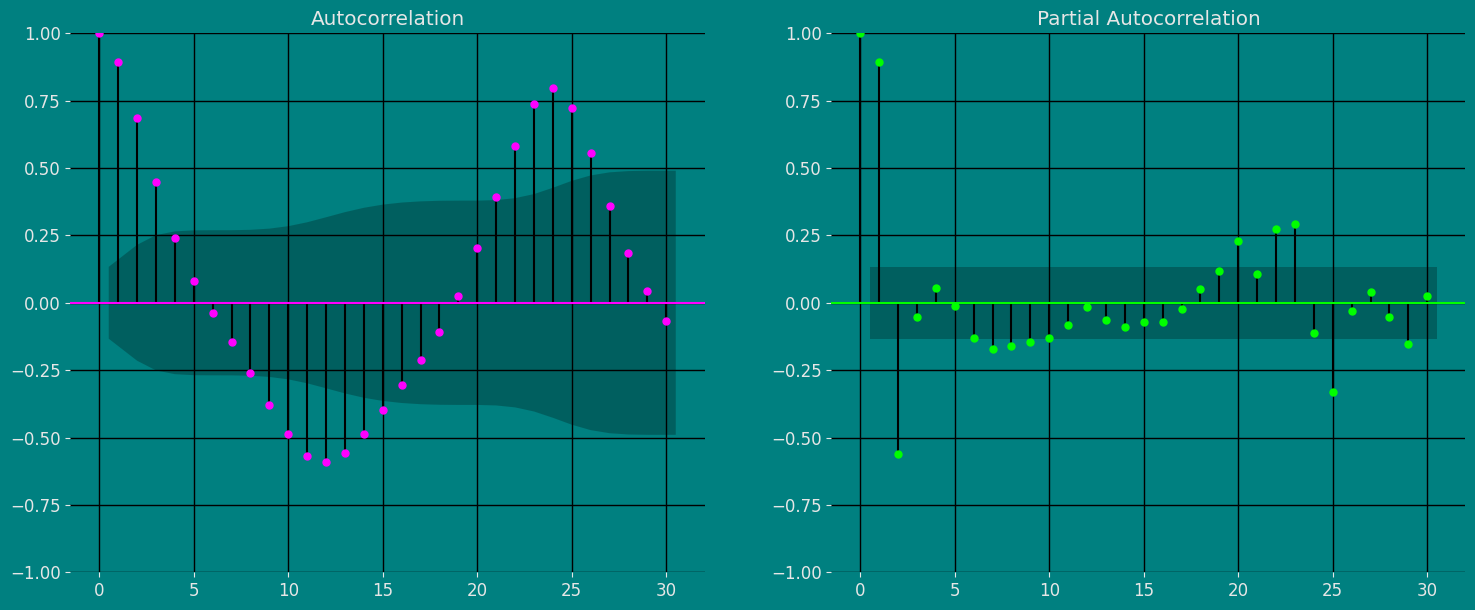

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2)

plot_acf(df["y"],  lags=30, ax=axs[0],color="fuchsia")
axs[0].set_title("Autocorrelation");

# Grafico
plot_pacf(df["y"],  lags=30, ax=axs[1],color="lime")
axs[1].set_title('Partial Autocorrelation')

#plt.savefig("Gráfico de Densidad y qq")
plt.show();

## Split the data into training and testing<a class="anchor" id="splitting"></a>

Let's divide our data into sets

1. Data to train our `Simple Exponential Smoothing (SES)`.
2. Data to test our model

For the test data we will use the last 30 hours to test and evaluate the performance of our model.

In [ ]:
train = df[df.ds<='2017-09-20 17:00:00']
test = df[df.ds>'2017-09-20 17:00:00']

In [ ]:
train.shape, test.shape

((186, 3), (30, 3))

## Implementation of SimpleExponentialSmoothing with StatsForecast <a class="anchor" id="implementation"></a>

### Load libraries

In [ ]:
from statsforecast import StatsForecast
from statsforecast.models import SimpleExponentialSmoothing

### Instantiating Model
We are going to build different models, for different values of alpha.

In [ ]:
horizon = len(test)
# We call the model that we are going to use
models = [SimpleExponentialSmoothing(alpha=0.1, alias="SES01"),
          SimpleExponentialSmoothing(alpha=0.5,alias="SES05"),
          SimpleExponentialSmoothing(alpha=0.8,alias="SES08")
          ]

We fit the models by instantiating a new StatsForecast object with the following parameters:

models: a list of models. Select the models you want from models and import them.

* `freq:` a string indicating the frequency of the data. (See [panda’s available frequencies](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).)

* `n_jobs:` n_jobs: int, number of jobs used in the parallel processing, use -1 for all cores.

* `fallback_model:` a model to be used if a model fails.

Any settings are passed into the constructor. Then you call its fit method and pass in the historical data frame.

In [ ]:
sf = StatsForecast(models=models, freq='h')

### Fit the Model

In [ ]:
sf.fit(df=train)

StatsForecast(models=[SES01,SES05,SES08])

Let's see the results of our Simple `Simple Exponential Smoothing model (SES)`. We can observe it with the following instruction:

In [ ]:
result01=sf.fitted_[0,0].model_
result05=sf.fitted_[0,1].model_
result08=sf.fitted_[0,2].model_
result01

{'mean': array([126112.90072589]),
 'fitted': array([       nan,  80115.   ,  80092.   ,  81015.3  ,  83106.77 ,
         86959.09 ,  89910.69 ,  91569.12 ,  92691.7  ,  94228.03 ,
         96417.73 ,  99878.96 , 104793.06 , 110072.76 , 114136.98 ,
        117652.78 , 120897.5  , 123285.75 , 126026.18 , 129807.56 ,
        133450.3  , 134057.28 , 131241.05 , 127794.945, 123267.445,
        118953.2  , 114591.38 , 111642.74 , 110686.47 , 112131.32 ,
        112721.19 , 112371.57 , 111381.914, 110467.73 , 111004.95 ,
        112958.45 , 116095.11 , 119382.6  , 122359.336, 124927.41 ,
        127315.664, 129567.1  , 131667.39 , 133444.66 , 135152.19 ,
        134549.97 , 131476.47 , 127546.32 , 123068.19 , 118392.875,
        114066.586, 110923.92 , 108711.03 , 109682.93 , 110233.64 ,
        110304.27 , 109159.84 , 108662.36 , 108662.625, 110460.36 ,
        113457.83 , 117359.05 , 120250.64 , 123027.58 , 125498.32 ,
        127523.484, 129699.64 , 132702.17 , 135540.45 , 135538.4  ,
   

As we can see, the result obtained above has an output in a dictionary, to extract each element from the dictionary we are going to use the `.get()` function to extract the element and then we are going to save it in a `pd.DataFrame()`.

In [ ]:
fitted=pd.DataFrame(result01.get("fitted"), columns=["fitted01"])
fitted["fitted05"]=result05.get("fitted")
fitted["fitted08"]=result08.get("fitted")
fitted["ds"]=df["ds"]
fitted

,fitted01,fitted05,fitted08,ds
0,NaN,NaN,NaN,2017-09-13 00:00:00
1,80115.000000,80115.00,80115.000000,2017-09-13 01:00:00
2,80092.000000,80000.00,79931.000000,2017-09-13 02:00:00
...,...,...,...,...
183,120765.039062,139195.00,141302.828125,2017-09-20 15:00:00
184,122847.531250,140392.50,141532.562500,2017-09-20 16:00:00
185,124623.781250,140501.25,140794.515625,2017-09-20 17:00:00


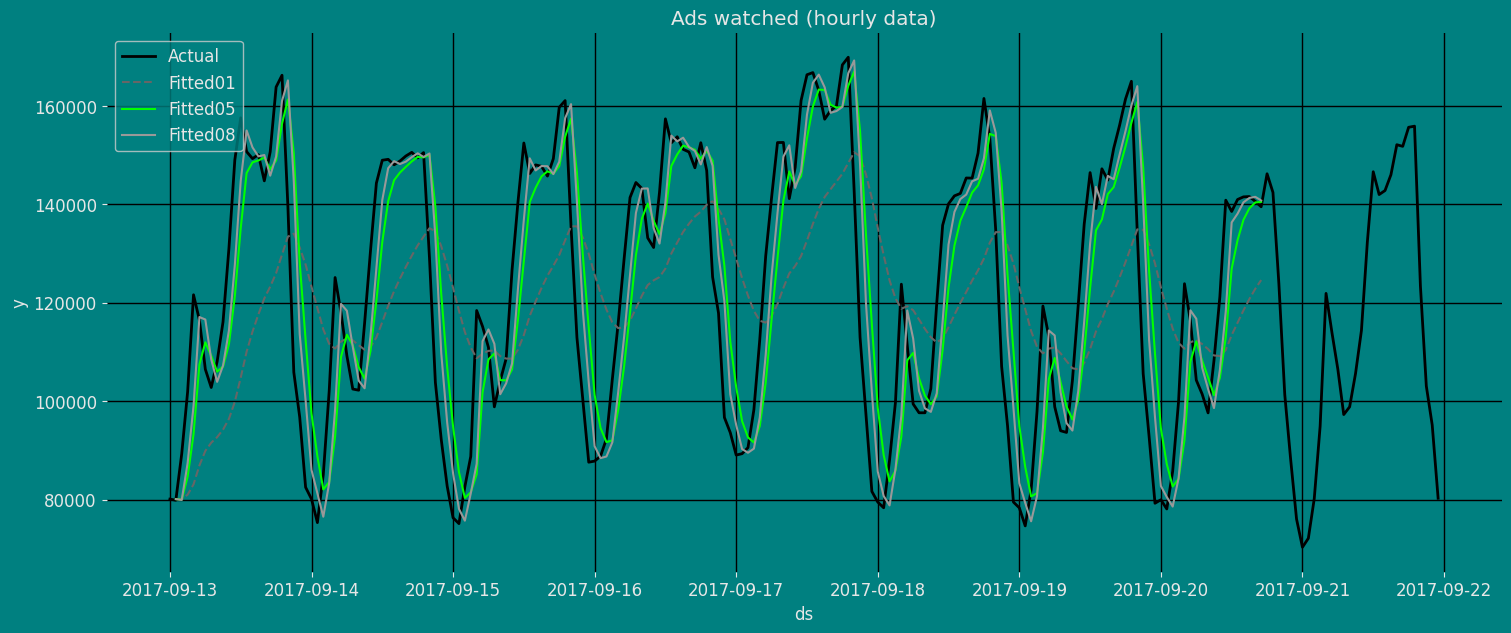

In [ ]:
sns.lineplot(df, x="ds", y="y", label="Actual", linewidth=2)
sns.lineplot(fitted,x="ds", y="fitted01", label="Fitted01", linestyle="--", )
sns.lineplot(fitted, x="ds", y="fitted05", label="Fitted05", color="lime")
sns.lineplot(fitted, x="ds", y="fitted08", label="Fitted08")
plt.title("Ads watched (hourly data)");
plt.show()

### Forecast Method

If you want to gain speed in productive settings where you have multiple series or models we recommend using the `StatsForecast.forecast` method instead of `.fit` and `.predict`.

The main difference is that the `.forecast` doest not store the fitted values and is highly scalable in distributed environments.

The forecast method takes two arguments: forecasts next `h` (horizon) and `level`.

* `h (int):` represents the forecast h steps into the future. In this case, 30 hours ahead.

The forecast object here is a new data frame that includes a column with the name of the model and the y hat values, as well as columns for the uncertainty intervals. Depending on your computer, this step should take around 1min.

In [ ]:
# Prediction
Y_hat = sf.forecast(df=train, h=horizon, fitted=True)
Y_hat.head()

,unique_id,ds,SES01,SES05,SES08
0,1,2017-09-20 18:00:00,126112.898438,140008.125,139770.90625
1,1,2017-09-20 19:00:00,126112.898438,140008.125,139770.90625
2,1,2017-09-20 20:00:00,126112.898438,140008.125,139770.90625
3,1,2017-09-20 21:00:00,126112.898438,140008.125,139770.90625
4,1,2017-09-20 22:00:00,126112.898438,140008.125,139770.90625


In [ ]:
values=sf.forecast_fitted_values()
values.head()

,unique_id,ds,y,SES01,SES05,SES08
0,1,2017-09-13 00:00:00,80115.0,NaN,NaN,NaN
1,1,2017-09-13 01:00:00,79885.0,80115.000000,80115.00,80115.000000
2,1,2017-09-13 02:00:00,89325.0,80092.000000,80000.00,79931.000000
3,1,2017-09-13 03:00:00,101930.0,81015.296875,84662.50,87446.203125
4,1,2017-09-13 04:00:00,121630.0,83106.773438,93296.25,99033.242188


### Predict method

To generate forecasts use the predict method.

The predict method takes two arguments: forecasts the next `h` (for horizon).
* `h (int):` represents the forecast $h$ steps into the future. In this case, 30 hours ahead.

The forecast object here is a new data frame that includes a column with the name of the model and the `y hat` values, as well as columns for the uncertainty intervals.

This step should take less than 1 second.

In [ ]:
forecast_df = sf.predict(h=horizon)
forecast_df

,unique_id,ds,SES01,SES05,SES08
0,1,2017-09-20 18:00:00,126112.898438,140008.125,139770.90625
1,1,2017-09-20 19:00:00,126112.898438,140008.125,139770.90625
2,1,2017-09-20 20:00:00,126112.898438,140008.125,139770.90625
...,...,...,...,...,...
27,1,2017-09-21 21:00:00,126112.898438,140008.125,139770.90625
28,1,2017-09-21 22:00:00,126112.898438,140008.125,139770.90625
29,1,2017-09-21 23:00:00,126112.898438,140008.125,139770.90625


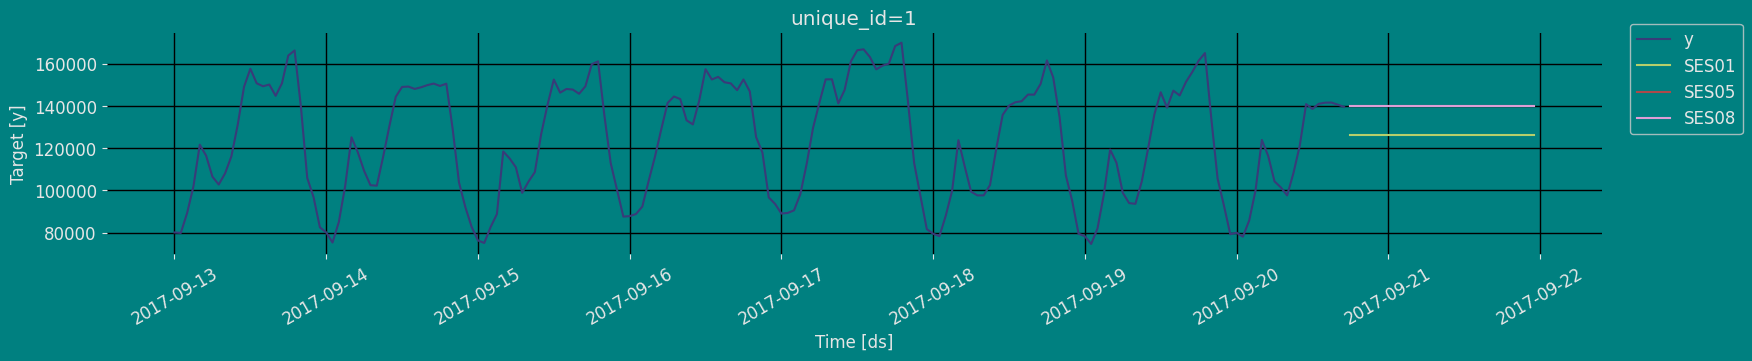

In [ ]:
sf.plot(train, forecast_df)

## Cross-validation <a class="anchor" id="cross_validate"></a>

In previous steps, we’ve taken our historical data to predict the future. However, to asses its accuracy we would also like to know how the model would have performed in the past. To assess the accuracy and robustness of your models on your data perform Cross-Validation.

With time series data, Cross Validation is done by defining a sliding window across the historical data and predicting the period following it. This form of cross-validation allows us to arrive at a better estimation of our model’s predictive abilities across a wider range of temporal instances while also keeping the data in the training set contiguous as is required by our models.

The following graph depicts such a Cross Validation Strategy:

![](https://raw.githubusercontent.com/Nixtla/statsforecast/main/nbs/imgs/ChainedWindows.gif)

### Perform time series cross-validation

Cross-validation of time series models is considered a best practice but most implementations are very slow. The statsforecast library implements cross-validation as a distributed operation, making the process less time-consuming to perform. If you have big datasets you can also perform Cross Validation in a distributed cluster using Ray, Dask or Spark.

In this case, we want to evaluate the performance of each model for the last 30 hourly `(n_windows=)`, forecasting every second months `(step_size=30)`. Depending on your computer, this step should take around 1 min.

The cross_validation method from the StatsForecast class takes the following arguments.

* `df:` training data frame

* `h (int):` represents h steps into the future that are being forecasted. In this case, 30 hours ahead.

* `step_size (int):` step size between each window. In other words: how often do you want to run the forecasting processes.

* `n_windows(int):` number of windows used for cross validation. In other words: what number of forecasting processes in the past do you want to evaluate.

In [ ]:
crossvalidation_df = sf.cross_validation(df=df,
                                         h=horizon,
                                         step_size=30,
                                         n_windows=3)

The crossvaldation_df object is a new data frame that includes the following columns:

* `unique_id:` series identifier
* `ds:` datestamp or temporal index
* `cutoff:` the last datestamp or temporal index for the `n_windows`.
* `y:` true value
* `model:` columns with the model’s name and fitted value.

In [ ]:
crossvalidation_df

,unique_id,ds,cutoff,y,SES01,SES05,SES08
0,1,2017-09-18 06:00:00,2017-09-18 05:00:00,99440.0,118499.953125,109816.250,112747.695312
1,1,2017-09-18 07:00:00,2017-09-18 05:00:00,97655.0,118499.953125,109816.250,112747.695312
2,1,2017-09-18 08:00:00,2017-09-18 05:00:00,97655.0,118499.953125,109816.250,112747.695312
...,...,...,...,...,...,...,...
87,1,2017-09-21 21:00:00,2017-09-20 17:00:00,103080.0,126112.898438,140008.125,139770.906250
88,1,2017-09-21 22:00:00,2017-09-20 17:00:00,95155.0,126112.898438,140008.125,139770.906250
89,1,2017-09-21 23:00:00,2017-09-20 17:00:00,80285.0,126112.898438,140008.125,139770.906250


## Model Evaluation <a class="anchor" id="evaluate"></a>

Now we are going to evaluate our model with the results of the predictions, we will use different types of metrics MAE, MAPE, MASE, RMSE, SMAPE to evaluate the accuracy.

In [ ]:
from functools import partial

import utilsforecast.losses as ufl
from utilsforecast.evaluation import evaluate

In [ ]:
evaluate(
    test.merge(Y_hat),
    metrics=[ufl.mae, ufl.mape, partial(ufl.mase, seasonality=24), ufl.rmse, ufl.smape],
    train_df=train,
)

,unique_id,metric,SES01,SES05,SES08
0,1,mae,25173.939583,29390.875000,29311.802083
1,1,mape,0.255088,0.316440,0.315339
2,1,mase,3.110288,3.631298,3.621528
3,1,rmse,28923.395381,36184.340869,36027.710540
4,1,smape,0.109972,0.124803,0.124542


## References <a class="anchor" id="references"></a>

1. [Changquan Huang • Alla Petukhina. Springer series (2022). Applied Time Series Analysis and Forecasting with Python.](https://link.springer.com/book/10.1007/978-3-031-13584-2) 
2. Ivan Svetunkov. [Forecasting and Analytics with the Augmented Dynamic Adaptive Model (ADAM)](https://openforecast.org/adam/)
3. [James D. Hamilton. Time Series Analysis Princeton University Press, Princeton, New Jersey, 1st Edition, 1994.](https://press.princeton.edu/books/hardcover/9780691042893/time-series-analysis)
4. [Nixtla SeasonalExponentialSmoothing API](../../models#class-simpleexponentialsmoothing)
5. [Pandas available frequencies](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).
6. [Rob J. Hyndman and George Athanasopoulos (2018). “Forecasting Principles and Practice (3rd ed)”](https://otexts.com/fpp3/tscv.html).
7. [Seasonal periods- Rob J Hyndman](https://robjhyndman.com/hyndsight/seasonal-periods/).